In [1]:
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback


sns.set(context='notebook', style='darkgrid', palette='muted', color_codes=True)

In [23]:
wandb.init(project='Iris_with_ANN',
           tags=['Iris','Learning','ANN'],
           config={"epochs":     250,
                   "batch_size": 12,
                   "Dropout":0.2,
                   "optimizer":  'Adam'
                  }
          )
# wandb agent kevinpulido89/Iris_with_ANN/o1i31srs

W&B Run: https://app.wandb.ai/kevinpulido89/Iris_with_ANN/runs/16abuf9i

# Clasificación de Iris con tf.keras y WandB

In [3]:
data = pd.read_csv("datasets/Iris.csv")
data.sample(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
70,71,5.9,3.2,4.8,1.8,Iris-versicolor
24,25,4.8,3.4,1.9,0.2,Iris-setosa
60,61,5.0,2.0,3.5,1.0,Iris-versicolor
51,52,6.4,3.2,4.5,1.5,Iris-versicolor
0,1,5.1,3.5,1.4,0.2,Iris-setosa


## EDA

## Wrangling


In [4]:
from sklearn.preprocessing import LabelEncoder

LabelChanger = LabelEncoder()

In [5]:
# Encoding categorical values with LabelEncoder: replaced Iris-setosa with 0, Iris-versicolor 1 and Iris-virginica 2 data.set_value(data['Species']=='Iris-setosa',['Species'],0)
LabelChanger.fit(data['Species'])
data['Clases'] = LabelChanger.transform(data['Species'])
# display(data.info())
data.sample(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Clases
123,124,6.3,2.7,4.9,1.8,Iris-virginica,2
133,134,6.3,2.8,5.1,1.5,Iris-virginica,2
35,36,5.0,3.2,1.2,0.2,Iris-setosa,0
15,16,5.7,4.4,1.5,0.4,Iris-setosa,0
118,119,7.7,2.6,6.9,2.3,Iris-virginica,2


In [6]:
X = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
Y = data['Clases']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.15,
                                                    random_state = 17,
                                                    stratify = Y)

In [11]:
Original_X_Train = X_train.copy()

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
# Mean Normalization (Standarize the features to follow the normal distribution, to obtain a faster & better classifier)
sc = StandardScaler()

X_train_array = sc.fit_transform(X_train.values) #calculate μ & σ(fit) and apply the transformation(transform)

# Assign the scaled data to a DataFrame & use the index and columns arguments to keep your original indices and column names:
X_train = pd.DataFrame(X_train_array, index=X_train.index, columns=X_train.columns)

In [14]:
# Center test data. Use the μ & σ computed (fitted) on training data
X_test_array = sc.transform(X_test.values)
X_test = pd.DataFrame(X_test_array, index=X_test.index, columns=X_test.columns)

## Red Neuronal

In [24]:
# Initializing Neural Network
model = Sequential(name='ANN')

model.add(Dense(units=12, activation='selu', kernel_initializer = 'lecun_normal', input_dim=4,))
model.add(Dropout(wandb.config.Dropout))
model.add(Dense(units=12, activation='selu', kernel_initializer = 'lecun_normal'))

model.add(Dense(units=3, activation='softmax', kernel_initializer = 'GlorotNormal'))
model.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total params: 255
Trainable params: 255
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=wandb.config.optimizer,
              metrics=['accuracy']
             )

In [26]:
Historia = model.fit(X_train.values,
                     Y_train.values,
                     epochs = wandb.config.epochs,
                     batch_size = wandb.config.batch_size,
                     validation_data=(X_test.values,Y_test.values),
                     callbacks=[WandbCallback()]
                    )

Train on 127 samples, validate on 23 samples
Epoch 1/250
127/127 [==============================] - 1s 10ms/sample - loss: 1.9916 - accuracy: 0.1811 - val_loss: 1.5075 - val_accuracy: 0.3043
Epoch 2/250
127/127 [==============================] - 0s 549us/sample - loss: 1.6063 - accuracy: 0.2756 - val_loss: 1.2089 - val_accuracy: 0.3043
Epoch 3/250
127/127 [==============================] - 0s 539us/sample - loss: 1.2861 - accuracy: 0.3858 - val_loss: 0.9905 - val_accuracy: 0.4348
Epoch 4/250
127/127 [==============================] - 0s 539us/sample - loss: 1.0224 - accuracy: 0.4646 - val_loss: 0.8437 - val_accuracy: 0.6957
Epoch 5/250
127/127 [==============================] - 0s 589us/sample - loss: 0.9039 - accuracy: 0.6220 - val_loss: 0.7525 - val_accuracy: 0.6522
Epoch 6/250
127/127 [==============================] - 0s 531us/sample - loss: 0.8242 - accuracy: 0.6850 - val_loss: 0.6868 - val_accuracy: 0.6087
Epoch 7/250
127/127 [==============================] - 0s 550us/sample - l

In [27]:
lss, acc = model.evaluate(X_train.values,
                          Y_train.values,
                          batch_size=wandb.config.batch_size,
                          verbose=2)

127/1 - 0s - loss: 0.0307 - accuracy: 0.9764


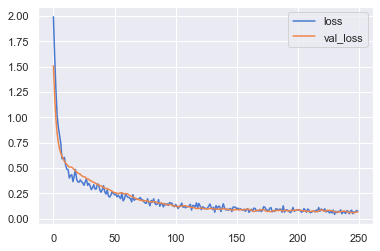

In [28]:
plt.plot(Historia.history['loss'], label='loss')
plt.plot(Historia.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

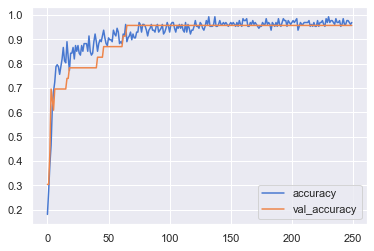

In [29]:
plt.plot(Historia.history['accuracy'], label='accuracy')
plt.plot(Historia.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [30]:
# the prediction results 
predicciones = model.predict_classes(X_test.values, batch_size=wandb.config.batch_size, verbose=1)

real_acc = np.sum(predicciones == Y_test)/23.0 * 100

print("Test Accuracy : " + str(real_acc) + '%')
print("Prediction :")
print(predicciones)
print("Target :")
print(np.asarray(Y_test,dtype="int32"))

23/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 2ms/sample
Test Accuration : 95.65217391304348%
Prediction :
[1 2 2 1 1 2 0 2 0 1 1 0 2 0 0 0 1 2 2 1 2 0 2]
Target :
[1 2 2 1 1 2 0 2 0 1 1 0 2 0 0 0 1 1 2 1 2 0 2]


### Mismo código pero ahora usaré SWEEP

https://colab.research.google.com/github/wandb/examples/blob/master/sweeps-python/notebook.ipynb

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

def train():

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from wandb.keras import WandbCallback

    hyperparametres={"epochs":     111,
                     "batch_size": 11,
                     "Dropout":    0.11,
                     "optimizer": 'Adam'
                    }

    wandb.init(config=hyperparametres)
    config = wandb.config

    print(">>>> Configuracion cargada:", dict(config))

    data = pd.read_csv('iris.csv')

    print('Iris loaded')

    LabelChanger = LabelEncoder()
    LabelChanger.fit(data['Species'])
    data['Clases'] = LabelChanger.transform(data['Species'])

    X = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
    Y = data['Clases']

    X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                        Y,
                                                        test_size = 0.15,
                                                        stratify = Y)

    # Mean Normalization (Standarize the features to follow the normal distribution, to obtain a faster & better classifier)
    sc = StandardScaler()

    X_train_array = sc.fit_transform(X_train.values) #calculate μ & σ(fit) and apply the transformation(transform)

    # Assign the scaled data to a DataFrame & use the index and columns arguments to keep your original indices and column names:
    X_train = pd.DataFrame(X_train_array, index=X_train.index, columns=X_train.columns)

    # Center test data. Use the μ & σ computed (fitted) on training data
    X_test_array = sc.transform(X_test.values)
    X_test = pd.DataFrame(X_test_array, index=X_test.index, columns=X_test.columns)

    # Initializing Neural Network
    model = Sequential(name='ANN')

    model.add(Dense(units=12, activation='selu', kernel_initializer = 'lecun_normal', input_dim=4,))
    model.add(Dropout(config.Dropout))
    model.add(Dense(units=12, activation='selu', kernel_initializer = 'lecun_normal'))

    model.add(Dense(units=3, activation='softmax', kernel_initializer = 'GlorotNormal'))
    model.summary()

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=config.optimizer,
                  metrics=['accuracy']
                 )

    Historia = model.fit(X_train.values,
                         Y_train.values,
                         epochs = config.epochs,
                         batch_size = config.batch_size,
                         validation_data = (X_test.values, Y_test.values),
                         callbacks=[WandbCallback()]
                        )

    # lss, acc = model.evaluate(X_train.values,
    #                           Y_train.values,
    #                           batch_size=config.batch_size,
    #                           verbose=2)

    # # Log metrics inside your training loop
    # metrics = {'accuracy': acc, 'loss': lss}
    # wandb.log(metrics)

    # print('Model accuracy:', acc)

    # # the prediction results
    # predicciones = model.predict_classes(X_test.values, batch_size=config.batch_size, verbose=1)

    # real_acc = np.sum(predicciones == Y_test)/23.0 * 100

    # print("Test Accuracy : " + str(real_acc) + '%')

    print('Finish!')

In [2]:
sweep_config = {
    'name': "SweepFromLocal",
    'method': 'grid',
    'parameters': {
        'Dropout':    {'values': [0.2, 0.25, 0.3, 0.35]},
        'batch_size': {'values': [12, 18, 24, 32]},
        'epochs':     {'values': [150, 200, 250, 300]}
        }
}

import wandb

sweep_id = wandb.sweep(sweep_config, project='Iris_with_ANN')
wandb.agent(sweep_id, function=train)

Create sweep with ID: fi3icenn
Sweep URL: https://app.wandb.ai/kevinpulido89/Iris_with_ANN/sweeps/fi3icenn
wandb: Agent Starting Run: m4r454c5 with config:
	Dropout: 0.5
	batch_size: 20
	epochs: 20


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


## Other ANN

In [ ]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from time import time
from math import sqrt
import pandas as pd
import math
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
def Distancia_Euclidiana(px1,py1,px2,py2):
    return sqrt((px2-px1)**2+(py2-py1)**2)

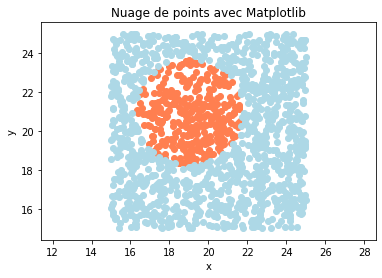

In [3]:
# Create data

N = 1500
x = 15 + 10 * np.random.rand(N)
y = 15 + 10 * np.random.rand(N)

xy = list(zip(x,y))
claseA = list()
claseB = list()
for t in xy:
    dist = Distancia_Euclidiana(19,21,t[0],t[1])
    if dist < math.e:
        claseA.append((t[0],t[1]))
    else:
        claseB.append((t[0],t[1]))
        
Ax, Ay = zip(*claseA)
Bx, By = zip(*claseB)

plt.scatter(Ax, Ay, c='coral')
plt.scatter(Bx, By, c='lightblue')

plt.title('Nuage de points avec Matplotlib')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
A = dict({
    'x':Ax,
    'y':Ay,
    'C':1.0
})

B = dict({
    'x':Bx,
    'y':By,
    'C':0.0
})
dfA = pd.DataFrame(A)
dfB = pd.DataFrame(B)
dataset = dfA.append(dfB, sort=False)
# dataset

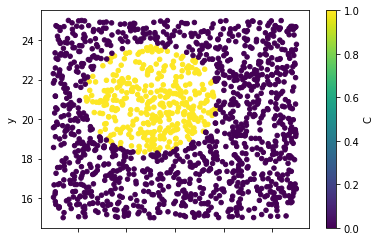

In [5]:
features = dataset.iloc[:,0:2]
clases = dataset['C']

X_train, X_test, y_train, y_test = train_test_split(features, clases, test_size=0.25, random_state=42)
dataset.plot.scatter(x='x',y='y',c='C', colormap='viridis')

In [6]:
clf = MLPClassifier(activation='relu',solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(16,8,4), random_state=1)

clf.fit(X_train, y_train) 

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 8, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [7]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = clf.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[260  29]
 [ 51  35]]
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       289
         1.0       0.55      0.41      0.47        86

    accuracy                           0.79       375
   macro avg       0.69      0.65      0.67       375
weighted avg       0.77      0.79      0.77       375



In [8]:
clf.predict(np.array([[19, 21]]))

array([1.])

In [9]:
# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
# define the keras model
model = Sequential()
model.add(Dense(32, input_dim=2, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu',kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# compile the keras model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# fit the keras model on the dataset
model.fit(X_train,
          y_train,
          epochs=50,
          validation_split=0.1,
          batch_size=10)

Train on 1012 samples, validate on 113 samples
Epoch 1/50
1012/1012 [==============================] - 5s 5ms/step - loss: 0.5348 - acc: 0.7302 - val_loss: 0.4744 - val_acc: 0.6814
Epoch 2/50
1012/1012 [==============================] - 1s 917us/step - loss: 0.4383 - acc: 0.7599 - val_loss: 0.4447 - val_acc: 0.7611
Epoch 3/50
1012/1012 [==============================] - 1s 1ms/step - loss: 0.4284 - acc: 0.7490 - val_loss: 0.4755 - val_acc: 0.7611
Epoch 4/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4157 - acc: 0.7540 - val_loss: 0.4272 - val_acc: 0.7611
Epoch 5/50
1012/1012 [==============================] - 1s 1ms/step - loss: 0.4156 - acc: 0.7559 - val_loss: 0.4388 - val_acc: 0.7080
Epoch 6/50
1012/1012 [==============================] - 1s 912us/step - loss: 0.4130 - acc: 0.7619 - val_loss: 0.5841 - val_acc: 0.6726
Epoch 7/50
1012/1012 [==============================] - 1s 1ms/step - loss: 0.4147 - acc: 0.7599 - val_loss: 0.4447 - val_acc: 0.7080
Epoch 8/50


In [13]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

1125/1125 [==============================] - 0s 163us/step
Accuracy: 73.69


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
# https://medium.com/@yugkhanna1/building-a-5-layer-cnn-model-with-keras-to-identify-handwritten-digits-complex-yet-simple-f06b8b375346

model = Sequential()

# First Layer
model.add(Conv2D(filters=6,
                 kernel_size=(5, 5),
                 strides=(1, 1),
                 padding='valid',
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

# Second Layer
model.add(Conv2D(filters=16,
                 kernel_size=(5, 5),
                 strides=(1, 1),
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       strides=(2, 2)))

# Fully connected
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units= 84, activation='relu'))
model.add(Dense(units= 10, activation='softmax'))

optimizer=Adam(lr=0.001)
model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               